In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
%matplotlib inline
import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
import json

with open('station_information.json') as f:
    station_data = json.load(f)
station_list = station_data['data']['stations']

#Get station capacity from the JSON info file at https://gbfs.citibikenyc.com/gbfs/fr/station_information.json
def getStationCapacity(station_name):
    for station in station_list:
        if station['name'] == station_name:
            return station['capacity']

# Warm-up questions

In [ ]:
data = pd.read_csv('202107-citibike-tripdata.csv')

In [3]:
# Turn columns to datetimes
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

# Get duration in minutes
data['duration'] = data['ended_at'] - data['started_at']
data['duration_min'] = data['duration'] / timedelta(minutes=1)

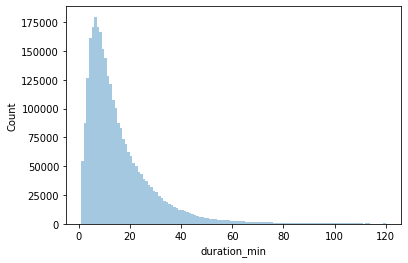

In [4]:
# 1. Plot duration
sns.distplot(round(data['duration_min']), bins=range(1, 121), hist=True, kde=False)
plt.ylabel('Count')
plt.show()

Here we see that most rides are under 20 minutes, with a long tail extending to rides over two hours long.

In [5]:
# 2. Average
data['duration_min'].mean()

18.024970316992295

The expected ride duration is 18 minutes, just under the twenty minute mark. This value is heavily influenced by outliers to the right, i.e. rides that are very long in duration.

In [6]:
# Variance
data['duration_min'].var()

6915.028501301067

The empirical variance of ride duration is over 6900, which means that the empiral standard deviation is over 83. Again, this is due to the presence of outliers and sometimes even observations that are incorrectly labeled, for example when a bike is taken but not docked properly.

In [7]:
# Percentage over 20 minutes
(data['duration_min'] > 20).mean()

0.24975125926516686

Here we see that almost a quarter of all rides were greater than 20 minutes long in duration.

In [8]:
# 3. Percentage over 20 minutes for members
data_member = data[data['member_casual'] == 'member']
(data_member['duration_min'] > 20).mean()

0.1942044473470034

We see here that most members do not usually ride for longer than 20 minutes, with only less than a fifth of members taking long rides. Conditioned on being a member, the probability of a ride over 20 minutes is just under 20%.

In [9]:
# 4. Percentage of members for rides over 25 minutes
data_long = data[data['duration_min'] > 25]
(data_long['member_casual'] == 'member').mean()

0.4828191891922421

If a bike ride is more than 25 minutes, then the chance that the ride belongs to a member is almost fifty percent.

# Project

In [3]:
df = pd.read_csv('202107-citibike-tripdata.csv', dtype={'start_station_id': str, 'end_station_id': str})
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,247BA541A9674BF3,classic_bike,2021-07-09 16:05:36,2021-07-09 16:18:09,5 Ave & E 93 St,7372.10,Frederick Douglass Blvd & W 117 St,7688.12,40.785785,-73.957481,40.805159,-73.954692,member
1,125C9ACA270A5E2D,classic_bike,2021-07-11 16:23:35,2021-07-11 16:29:07,5 Ave & E 93 St,7372.10,E 88 St & Park Ave,7293.10,40.785785,-73.957481,40.781411,-73.955959,member
2,2E26264BCC15BA05,classic_bike,2021-07-23 06:22:40,2021-07-23 06:36:13,34 St & 38 Ave,6453.02,McGuinness Blvd & Eagle St,5977.01,40.752443,-73.929737,40.735550,-73.952840,member
3,A56D23A088563424,classic_bike,2021-07-05 16:08:10,2021-07-05 16:36:00,Lenox Ave & W 111 St,7602.05,5 Ave & E 78 St,7161.08,40.798786,-73.952300,40.776321,-73.964274,casual
4,1451F4BB884C5335,classic_bike,2021-07-26 12:28:57,2021-07-26 12:30:21,6 Ave & Broome St,5610.09,6 Ave & Canal St,5500.07,40.724310,-74.004730,40.722438,-74.005664,casual


In [4]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [5]:
df['duration_min'] = (df['ended_at'] - df['started_at']) / timedelta(minutes=1)
df['start_hour'] = df['started_at'].dt.hour
df['start_day'] = df['started_at'].dt.day 
df['weekday'] = df['started_at'].dt.weekday

In [6]:
#Choose top 3 stations with the most activity
print(df.groupby('start_station_name').size().sort_values(ascending=False)[:3], '\n')
print(df.groupby('end_station_name').size().sort_values(ascending=False)[:3])

top_stations = list(df.groupby('start_station_name').size().sort_values(ascending=False)[:3].index)

#Filter data using these 3 stations
df_filtered = df[df['start_station_name'].isin(top_stations) | df['end_station_name'].isin(top_stations)]

#Filter weekdays
df_filtered = df_filtered[df_filtered['weekday'] < 5]

#Filter outlier durations
df_filtered = df_filtered[~((df_filtered['start_station_name'] == df_filtered['end_station_name'])
                          & (df_filtered['duration_min'] < 1))]
df_filtered = df_filtered[(df_filtered['duration_min'] > 0) & (df_filtered['duration_min'] < 120)]

start_station_name
7 Ave & Central Park South    14254
E 17 St & Broadway            13600
W 21 St & 6 Ave               13488
dtype: int64 

end_station_name
7 Ave & Central Park South    14300
E 17 St & Broadway            13959
W 21 St & 6 Ave               13559
dtype: int64


<AxesSubplot:xlabel='start_hour', ylabel='count'>

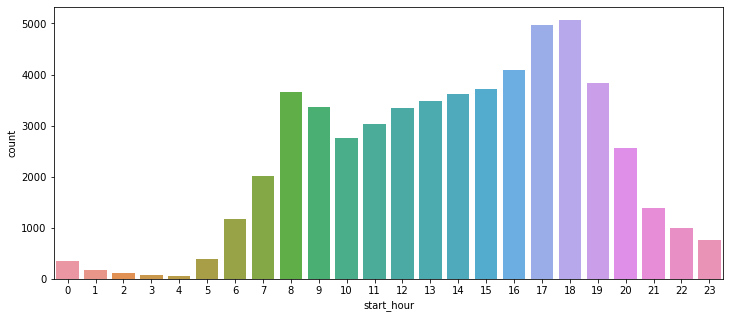

In [6]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.countplot(data=df_filtered, x="start_hour")

In [7]:
#Filter weekdays of the month to loop through
dates = pd.date_range(start='7/1/2021', end='7/31/2021')
dates = dates[dates.weekday < 5]

def generateTransProbMat(station, dates, time_block):
    #Define time range of each block
    if time_block == 'morning':
        times_start = pd.date_range("7:00", "10:55", freq="5min")
        times_end = pd.date_range("7:05", "11:00", freq="5min")
    elif time_block == 'evening':
        times_start = pd.date_range("15:00", "18:55", freq="5min")
        times_end = pd.date_range("15:05", "19:00", freq="5min")
    
    #Create dataframes of incoming and outgoing traffic
    df_outgoing = df_filtered[df_filtered['start_station_name'] == station]
    df_incoming = df_filtered[df_filtered['end_station_name'] == station]
    frequency = {}
    for date in dates:
        for start_time, end_time in zip(times_start, times_end):
            #Count number of bikes leaving the station during each 5-min block
            outgoing_num = df_outgoing[(df_outgoing['started_at'].dt.date == date) &
                                       (df_outgoing['started_at'].dt.time >= start_time.time()) &
                                       (df_outgoing['started_at'].dt.time < end_time.time())].shape[0]
            #Count number of bikes going to the station during each 5-min block
            incoming_num = df_incoming[(df_incoming['ended_at'].dt.date == date) &
                                       (df_incoming['ended_at'].dt.time >= start_time.time()) &
                                       (df_incoming['ended_at'].dt.time < end_time.time())].shape[0]
            delta = incoming_num - outgoing_num
            #Tally the frequency of state changes in a dictionary
            if delta in frequency:
                frequency[delta] += 1
            else:
                frequency[delta] = 1
                
    cap = getStationCapacity(station)
    #Create the transition probability matrix from the frequency dictionary
    mat = np.zeros((cap+1,cap+1))
    for i in range(cap+1):
        for freq in frequency.keys():
            #Find where the next state is
            j = i + freq
            #Do nothing if the state change would exceed the capacity of the station or become negative
            if j >= cap+1 or j < 0:
                continue
            #P_ij = number of times i transitioned to j/total number of transitions
            else:
                mat[i,j] = frequency[freq]/sum(frequency.values())
    return mat

In [8]:
#Create a Pythonic linear algebra system to solve for stationary distribution.
#See math here: https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e
def calculateStatDist(probMat):
    A = np.append(np.transpose(probMat) - np.identity(probMat.shape[0]), [np.ones(probMat.shape[0])], axis=0)
    b = np.transpose(np.append(np.zeros(probMat.shape[0]), 1))
    pis = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    return pis


The transition probability matrix for the 7 Ave & Central Park South station in the morning is:
[[0.24337121 0.18655303 0.09280303 0.04734848 0.01799242 0.00568182
  0.00094697 0.         0.         0.00094697 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.18276515 0.24337121 0.18655303 0.09280303 0.04734848 0.01799242
  0.00568182 0.00094697 0.         0.         0.00094697 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1155303  0.18276515 0.24337121 0.18655303 0.09280303 0.04734848
  0.0


The transition probability matrix for the 7 Ave & Central Park South station in the evening is:
[[0.24242424 0.16098485 0.09280303 0.05776515 0.02556818 0.02083333
  0.01231061 0.00757576 0.00473485 0.00094697 0.00094697 0.00094697
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.13636364 0.24242424 0.16098485 0.09280303 0.05776515 0.02556818
  0.02083333 0.01231061 0.00757576 0.00473485 0.00094697 0.00094697
  0.00094697 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10795455 0.13636364 0.24242424 0.16098485 0.09280303 


The transition probability matrix for the E 17 St & Broadway station in the morning is:
[[0.25568182 0.17518939 0.13636364 0.09943182 0.05018939 0.02083333
  0.00852273 0.00662879 0.00662879 0.00189394 0.00094697 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.14015152 0.25568182 0.17518939 0.13636364 0.09943182 0.05018939
  0.02083333 0.00852273 0.00662879 0.00662879 0.00189394 0.00094697
  0.         0.         0.         0.         0.         0.
  0.         0.         0.       

The stationary distribution for the E 17 St & Broadway station in the morning is:
[0.00106041 0.00161341 0.00220905 0.00283337 0.00345174 0.00406084
 0.00466016 0.00525382 0.00584223 0.00641993 0.00698849 0.00754706
 0.00809572 0.00863432 0.00916276 0.00968107 0.0101892  0.01068714
 0.01117487 0.0116524  0.0121197  0.01257678 0.01302365 0.01346029
 0.0138867  0.0143029  0.01470887 0.01510461 0.01549013 0.01586543
 0.0162305  0.01658534 0.01692997 0.01726436 0.01758853 0.01790248
 0.01820619 0.01849968 0.01878294 0.01905597 0.01931876 0.01957131
 0.0198136  0.02004561 0.02026733 0.0204787  0.02067967 0.02087012
 0.02104989 0.02121873 0.02137624 0.02152181 0.02165445 0.02177265
 0.02187403 0.02195488 0.02200942 0.0220285  0.02199815 0.02189586
 0.0216879  0.02132156 0.02068942 0.01972348 0.01815006 0.01579693
 0.01242064]

The steady-state number of bikes of the E 17 St & Broadway station in the morning is 40.32375505424613

The transition probability matrix for the E 17 St & Broadway st


The transition probability matrix for the W 21 St & 6 Ave station in the morning is:
[[0.24715909 0.19318182 0.13731061 0.08238636 0.03693182 0.01420455
  0.00852273 0.00094697 0.00189394 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.15625    0.24715909 0.19318182 0.13731061 0.08238636 0.03693182
  0.01420455 0.00852273 0.00094697 0.00189394 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.       


The transition probability matrix for the W 21 St & 6 Ave station in the evening is:
[[0.19602273 0.14299242 0.09659091 0.06723485 0.03219697 0.01231061
  0.00378788 0.00189394 0.00094697 0.         0.00094697 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.15340909 0.19602273 0.14299242 0.09659091 0.06723485 0.03219697
  0.01231061 0.00378788 0.00189394 0.00094697 0.         0.00094697
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0

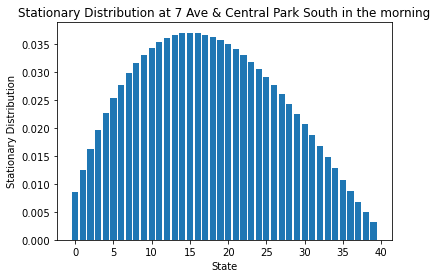

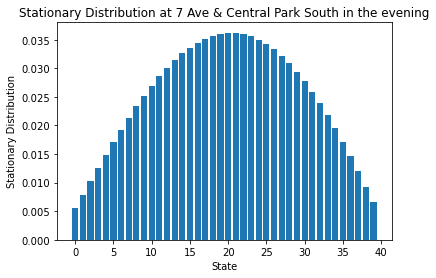

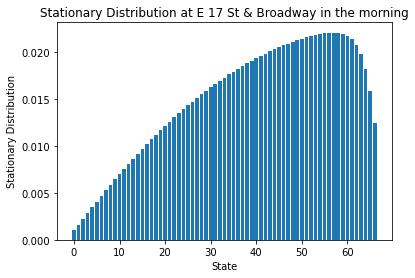

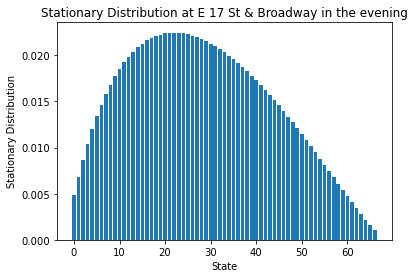

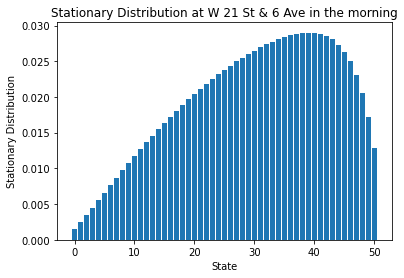

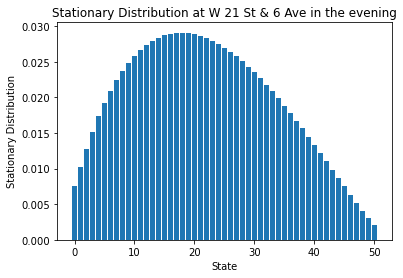

In [12]:
#Output the transition probability matrix and stationary distribution for each of the 3 stations during the morning and evening
for station in top_stations:
    for time_block in ['morning', 'evening']:
        probMat = generateTransProbMat(station, dates, time_block)
        pis = calculateStatDist(probMat)
        print('\nThe transition probability matrix for the {0} station in the {1} is:'.format(station, time_block))
        print(probMat)
        print('\nThe stationary distribution for the {0} station in the {1} is:'.format(station, time_block))
        print(pis)
        steady_state = np.sum(np.multiply(range(getStationCapacity(station)+1), pis))
        print('\nThe steady-state number of bikes of the {0} station in the {1} is {2}'.format(station, time_block, steady_state))
        plt.figure()
        plt.bar(range(getStationCapacity(station)+1), pis)
        plt.title('Stationary Distribution at {0} in the {1}'.format(station, time_block))
        plt.xlabel('State')
        plt.ylabel('Stationary Distribution')